<a href="https://colab.research.google.com/github/etomoscow/DL-in-NLP/blob/master/hw3/task1%2C2_character_lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2. Language modeling.

This task is devoted to language modeling. Its goal is to write in PyTorch an RNN-based language model. Since word-based language modeling requires long training and is memory-consuming due to large vocabulary, we start with character-based language modeling. We are going to train the model to generate words as sequence of characters. During training we teach it to predict characters of the words in the training set.



## Task 1. Character-based language modeling: data preparation (15 points).

We train the language models on the materials of **Sigmorphon 2018 Shared Task**. First, download the Russian datasets.

In [1]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2020-03-27 07:47:11--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533309 (521K) [text/plain]
Saving to: ‘russian-train-high’

russian-train-high  100%[===================>] 520.81K  --.-KB/s    in 0.04s   

2020-03-27 07:47:11 (13.4 MB/s) - ‘russian-train-high’ saved [533309/533309]

--2020-03-27 07:47:14--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

**1.1 (1 points)**
All the files contain tab-separated triples ```<lemma>-<form>-<tags>```, where ```<form>``` may contain spaces (*будете соответствовать*). Write a function that loads a list of all word forms, that do not contain spaces.  

In [0]:
def read_infile(infile):
    """
    implements simple data loader
    
    input: raw file 
    output: words (array-like)
    """
    words, tags = [], []
    with open(infile, 'r', encoding='utf-8') as ffile:
        for string in ffile:
            if len(string.strip().split('\t')) !=3:
                continue
            words.append(string.strip().split('\t')[0].lower())
            tags.append(string.strip().split('\t')[2])
    return words

In [3]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

10000 1000 1000
валлонский незаконченный истрёпывать личный серьга необоснованный тютя зарасти облётывать идеальный


**1.2 (2 points)** Write a **Vocabulary** class that allows to transform symbols into their indexes. The class should have the method ```__call__``` that applies this transformation to sequences of symbols and batches of sequences as well. You can also use [SimpleVocabulary](https://github.com/deepmipt/DeepPavlov/blob/c10b079b972493220c82a643d47d718d5358c7f4/deeppavlov/core/data/simple_vocab.py#L31) from DeepPavlov. Fit an instance of this class on the training data.

In [4]:
PAD_token = '<PAD>'   # Used for padding short sentences
BEGIN_token = '<BEGIN>'   # Start-of-sentence token
END_token = '<END>'   # End-of-sentence token

class Vocabulary(object):
    """
    implements a simple vocabulary (thanks to kdnuggets.com)

    """
    
    def fit(self, data, show_sets=False):
        terms = set(term for word in data for term in word)
        self._terms = [PAD_token, END_token, BEGIN_token] + sorted(terms)
        self.w2i = {word:ind for ind, word in enumerate(self._terms)}
        self.i2w = {ind:word for ind, word in enumerate(self._terms)}
        
        if show_sets:
            print('\nTerms:', self._terms)
            print('\nWord2Index dict:', self.w2i)
        return self

    def __call__(self, data):
        '''
        applies .transform method to the given data

        args:
            data - input dataset
        
        output:
            transformed dataset with indexes from Word2Index mapping
        '''
        transformed_data = [[self.w2i[term] for term in word] for word in data]
        return transformed_data

    def __len__(self):
        return len(self._terms)
    
    def word2idx(self, word):
        return self.w2i[word]
    
    def idx2word(self, ind):
        return self.i2w[ind]

vocab = Vocabulary()
vocab.fit([list(x) for x in train_words], show_sets=True)
print(len(vocab))


Terms: ['<PAD>', '<END>', '<BEGIN>', ' ', '-', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']

Word2Index dict: {'<PAD>': 0, '<END>': 1, '<BEGIN>': 2, ' ': 3, '-': 4, 'а': 5, 'б': 6, 'в': 7, 'г': 8, 'д': 9, 'е': 10, 'ж': 11, 'з': 12, 'и': 13, 'й': 14, 'к': 15, 'л': 16, 'м': 17, 'н': 18, 'о': 19, 'п': 20, 'р': 21, 'с': 22, 'т': 23, 'у': 24, 'ф': 25, 'х': 26, 'ц': 27, 'ч': 28, 'ш': 29, 'щ': 30, 'ъ': 31, 'ы': 32, 'ь': 33, 'э': 34, 'ю': 35, 'я': 36, 'ё': 37}
38


In [0]:
PAD_token = vocab.word2idx(PAD_token)
END_token = vocab.word2idx(END_token)
BEGIN_token = vocab.word2idx(BEGIN_token)

**1.3 (2 points)** Write a **Dataset** class, which should be inherited from ```torch.utils.data.Dataset```. It should take a list of words and the ```vocab``` as initialization arguments.

In [0]:
import torch
from torch.utils.data import Dataset as TorchDataset

class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab, index=0, batch_size=1):
        self.data = data
        self.vocab = vocab
        self.index = index
        self.batch_size = batch_size
    def __getitem__(self, data):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        global index
        data = self.data
        batch_size = self.batch_size
        batch = []
        target = []
        block = []

        for _ in range(batch_size):
            word = data[self.index]
            word_t = vocab.__call__([word])[0]
            target = word_t + [END_token]
            word_t = [BEGIN_token] + word_t
            
            block.append((word_t, target, len(word)))
            self.index = (self.index + 1) % len(data)
            
        block = sorted(block, key=lambda x: x[2], reverse=True)
        real_batch = torch.FloatTensor([x[0] for x in block][0])
        real_target = torch.FloatTensor([x[1] for x in block][0])
        #real_length = torch.FloatTensor([x[2] for x in block][0])
        return (real_batch, real_target)

    def __len__(self):
        return len(self.data) // self.batch_size

In [0]:
index = 0 
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

**1.4 (3 points)** Use a standard ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with ```batch_size=1```.

In [30]:
from torch.utils.data import DataLoader

loader =  DataLoader(train_dataset, batch_size=1)
for batch, i in zip(loader, range(10)):
    print (batch[0].shape, batch[1].shape)

torch.Size([1, 11]) torch.Size([1, 11])
torch.Size([1, 14]) torch.Size([1, 14])
torch.Size([1, 12]) torch.Size([1, 12])
torch.Size([1, 7]) torch.Size([1, 7])
torch.Size([1, 7]) torch.Size([1, 7])
torch.Size([1, 15]) torch.Size([1, 15])
torch.Size([1, 5]) torch.Size([1, 5])
torch.Size([1, 8]) torch.Size([1, 8])
torch.Size([1, 11]) torch.Size([1, 11])
torch.Size([1, 10]) torch.Size([1, 10])


**(1.5) 1 point** Explain, why this does not work with larger batch size.

**(1.6) 5 points** Write a function **collate** that allows you to deal with batches of greater size. See [discussion](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8) for an example. Implement your function as a class ```__call__``` method to make it more flexible.

In [0]:
def pad_tensor(vec, length, dim, pad_symbol=0):
    """
    Pads a vector ``vec`` up to length ``length`` along axis ``dim`` with pad symbol ``pad_symbol``.
    """
    dtype = torch.FloatTensor
    #print('vec shape:',vec.shape,'len',length)
    pad_size = list(vec.shape)
    if length > vec.size(dim):
        pad_size[dim] = length - vec.size(dim)
        #print('pad_size',pad_size)
        #print(torch.cat([vec.type(dtype), torch.zeros(*pad_size)], dim=dim))
        return torch.cat([vec.type(dtype), torch.zeros(*pad_size)], dim=dim)
    else:
        return vec 

class Padder:
    '''
    padding tool, pads batches according to the needed shape
    '''
    def __init__(self, dim=0, pad_symbol=0):
        '''
        args:
            dim - the dimension to be padded
            pad_symbol - the symbol to be used in padding
        '''
        self.dim = dim
        self.pad_symbol = pad_symbol
        
    def pad_collate(self, batch):
        '''
        args:
            batch - list(batch, target)

        return:
            x - Tensor of all examples in 'batch' after padding
            y - LongTensor of target in batch
        '''
        newbatch = []
        max_length = max(list(map(lambda x: x[0].shape[self.dim], batch)))
        for source, target in batch:
            newbatch.append((pad_tensor(source, max_length, self.dim),
                             pad_tensor(target, max_length, self.dim),
                             max_length))
            newbatch = sorted(newbatch, key= lambda x: x[2], reverse=True)
        xs = torch.stack(list(map(lambda x: x[0], newbatch)), dim=0).long()
        ys = torch.stack(list(map(lambda x: x[1], newbatch)), dim=0).long()
        lens = torch.as_tensor([x[2] for x in newbatch], dtype=torch.int64)
        return xs, ys, lens

    def __call__(self, batch):
        return self.pad_collate(batch)

**(1.7) 1 points** Again, use ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with the batch size you like.

In [84]:
from torch.utils.data import DataLoader
index = 0
loader = DataLoader(train_dataset, batch_size=5, collate_fn=Padder(dim=0, pad_symbol=0))
for batch, i in zip(loader, range(9)):
    if i==0:
        print('batch tensor type:', batch[0].type(), batch[1].type())
    print(batch[0].shape, batch[1].shape, batch[2])
    

batch tensor type: torch.LongTensor torch.LongTensor
torch.Size([5, 17]) torch.Size([5, 17]) tensor([17, 17, 17, 17, 17])
torch.Size([5, 13]) torch.Size([5, 13]) tensor([13, 13, 13, 13, 13])
torch.Size([5, 15]) torch.Size([5, 15]) tensor([15, 15, 15, 15, 15])
torch.Size([5, 43]) torch.Size([5, 43]) tensor([43, 43, 43, 43, 43])
torch.Size([5, 16]) torch.Size([5, 16]) tensor([16, 16, 16, 16, 16])
torch.Size([5, 17]) torch.Size([5, 17]) tensor([17, 17, 17, 17, 17])
torch.Size([5, 12]) torch.Size([5, 12]) tensor([12, 12, 12, 12, 12])
torch.Size([5, 14]) torch.Size([5, 14]) tensor([14, 14, 14, 14, 14])
torch.Size([5, 23]) torch.Size([5, 23]) tensor([23, 23, 23, 23, 23])


## Task 2. Character-based language modeling. (35 points)

**2.1 (5 points)** Write a network that performs language modeling. It should include three layers:
1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (you may use https://pytorch.org/docs/stable/nn.html#gru).
3. A **Linear** layer with ``softmax`` activation that produces the output distribution for each symbol.

In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F

device_cpu = torch.device('cpu')

class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_dim, num_layers, dropout=0.):
        super(RNNLM, self).__init__()
        self.embeddings_dim = embeddings_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.in_embs = nn.Embedding(vocab_size, embeddings_dim, padding_idx=PAD_token)
        self.lstm = nn.LSTM(embeddings_dim, hidden_dim, num_layers, dropout=dropout)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, inputs):
        embs = self.in_embs(inputs)
        out, f = self.lstm(embs)
        out = self.output_layer(out)
        scores = F.log_softmax(out,dim=-1)
        return scores

    def init_hidden(self, batch_size):
        '''
        poeqgjopiwjOPIj
        '''
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim, device = device), torch.zeros(self.num_layers, batch_size, self.hidden_dim, device = device)

**2.2 (1 points)** Write a function ``validate_on_batch`` that takes as input a model, a batch of inputs and a batch of outputs, and the loss criterion, and outputs the loss tensor for the whole batch. This loss should not be normalized.

In [0]:
def validate_on_batch(model, criterion, x, y, batch_size, lens):
    score = model.forward(x).to(device)
    loss = criterion(scores.view(batch_size_ * max(lens), -1).to(dtype=torch.float32),
                     y.view(batch_size*max(lens)))    
    return loss

**2.3 (1 points)** Write a function ``train_on_batch`` that accepts all the arguments of ``validate_on_batch`` and also an optimizer, calculates loss and makes a single step of gradient optimization. This function should call ``validate_on_batch`` inside.

In [0]:
def train_on_batch(model, criterion, x, y, lens, optimizer):
    
    x = x.to(device)
    y = y.to(device)

    batch_size_ = x.shape[0]

    loss = validate_on_batch(model,criterion,x,y,batch_size_,lens)

    return losses

**2.4 (3 points)** Write a training loop. You should define your ``RNNLM`` model, the criterion, the optimizer and the hyperparameters (number of epochs and batch size). Then train the model for a required number of epochs. On each epoch evaluate the average training loss and the average loss on the validation set. 

**2.5 (3 points)** Do not forget to average your loss over only non-padding symbols, otherwise it will be too optimistic.

In [177]:
import math 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = RNNLM(vocab_size=vocab.__len__(),
              embeddings_dim=vocab.__len__(),
              hidden_dim=256,
              num_layers=2,
              dropout=0.5).to(device)

loss_func = nn.NLLLoss(reduction='sum', ignore_index=PAD_token)
opt = torch.optim.Adam(model.parameters(), lr=0.03)

dev_perp = []
train_perp = []
losses_train = []
losses_dev = []

num_epochs = 500
print_every = 10

for epoch in range(num_epochs):
    sum_loss_train = 0
    sum_loss_dev = 0
    total_tokens_train = 0
    total_tokens_dev = 0

    
    for batch_train, target_train, lens in DataLoader(train_dataset,
                                                batch_size=100,
                                                collate_fn=Padder(dim=0, pad_symbol=0)):
        model.train()
        batch_train = batch_train.to(device)
        target_train = target_train.to(device)

        batch_size_ = batch_train.shape[0]
        batch_len = batch_train.shape[1]
        scores = model.forward(batch_train).to(device)
        loss = loss_func(scores.view(batch_size_*max(lens),-1).to(dtype=torch.float32), target_train.view(batch_size_*max(lens)))
        sum_loss_train = sum_loss_train + loss.item()
        total_tokens_train += float(batch_size_ + sum(lens))
        
        if model.training:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        perp_train = math.exp(sum_loss_train / total_tokens_train)
        loss_train = sum_loss_train / total_tokens_train
    losses_train.append(loss_train)
    train_perp.append(perp_train)
    
    if epoch % print_every == 0:
        print('Epoch: {}, loss:{}, perp:{}'.format(epoch, round(loss_train,4), round(perp_train,4)))

    
    for batch_eval, target_eval, lens in DataLoader(dev_dataset,
                                                batch_size=10,
                                                collate_fn=Padder(dim=0, pad_symbol=0)):
        model.eval()
        batch_eval = batch_eval.to(device=device)
        target_eval = target_eval.to(device=device)

        with torch.no_grad():
            batch_size_ = batch_eval.shape[0]
            batch_len = batch_eval.shape[1]
            scores = model.forward(batch_eval).to(device=device)
            loss = loss_func(scores.view(batch_size_*max(lens), -1).to(dtype=torch.float32), target_eval.view(batch_size_*max(lens)))
            sum_loss_dev = sum_loss_dev + loss.item()
            total_tokens_dev += float(batch_size_ + sum(lens))

        perp_dev = math.exp(sum_loss_dev / total_tokens_dev)
        loss_dev = sum_loss_dev / total_tokens_dev
    losses_dev.append(loss_dev)
    dev_perp.append(perp_dev)
    if epoch % print_every == 0:
        print('epoch: {}, val loss:{}, val perp:{}'.format(epoch, round(loss_dev,4), round(perp_dev,4)))

Epoch: 0, loss:1.209, perp:3.35
epoch: 0, val loss:1.5228, val perp:4.5853
Epoch: 10, loss:0.9935, perp:2.7006
epoch: 10, val loss:1.4345, val perp:4.1975
Epoch: 20, loss:0.9823, perp:2.6706
epoch: 20, val loss:1.4346, val perp:4.1981
Epoch: 30, loss:0.9799, perp:2.6642
epoch: 30, val loss:1.4362, val perp:4.2046
Epoch: 40, loss:0.9797, perp:2.6637
epoch: 40, val loss:1.4405, val perp:4.2229
Epoch: 50, loss:0.9777, perp:2.6585
epoch: 50, val loss:1.4452, val perp:4.2426
Epoch: 60, loss:0.9795, perp:2.6632
epoch: 60, val loss:1.4433, val perp:4.2347
Epoch: 70, loss:0.9766, perp:2.6554
epoch: 70, val loss:1.449, val perp:4.2587
Epoch: 80, loss:0.9757, perp:2.653
epoch: 80, val loss:1.449, val perp:4.2587
Epoch: 90, loss:0.977, perp:2.6565
epoch: 90, val loss:1.4521, val perp:4.2721
Epoch: 100, loss:0.9764, perp:2.6549
epoch: 100, val loss:1.4519, val perp:4.2714
Epoch: 110, loss:0.9762, perp:2.6544
epoch: 110, val loss:1.4545, val perp:4.2824
Epoch: 120, loss:0.9754, perp:2.6521
epoch: 1

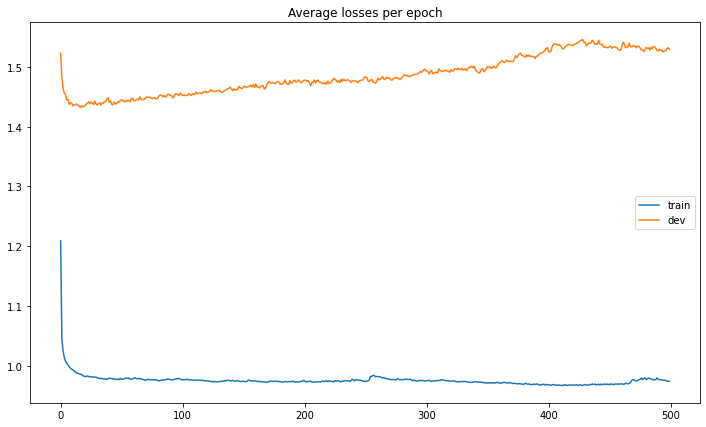

In [178]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,7))
plt.title('Average losses per epoch')
plt.plot(losses_train, label='train')
plt.plot(losses_dev, label='dev')
plt.legend(loc='best')

=**2.6 (5 points)** Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.

In [0]:
import numpy as np 
import pandas as pd 

def predict_on_batch(loader, model, n=20):
    hidden = model.init_hidden(batch_size=1)
    probabilities = []
    ii = 0
    for x, y, lens in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.shape[0]
        model.eval()
        scores = model.forward(x)[0].to(device='cpu').detach().numpy()
        y = y.to(device='cpu')
        score_e = np.exp(scores)
        y_w = [vocab.idx2word(i) for i in y[0].detach().numpy()]
        pred_w = [vocab.idx2word(i) for i in np.argmax(scores, axis=1)]
        temp = []
        for j in range(len(scores)):
            temp.append(math.exp(scores[j, y[0,j]]))
        probabilities.append((np.prod(temp),
                             lens[0],
                             1 / vocab.__len__()**lens[0]))
        temp = np.round(temp, 2)
        out_df = pd.DataFrame({i : [pred_w[i], y_w[i], temp[i]] for i,_ in enumerate(temp)})
        if ii > len(loader)-1-n:
            print('-'*70)
            print(out_df)
            print('\nProbs: {}\t word len: {}'.format(probabilities[-1][0],
                                                                          probabilities[-1][1]))
            print('-'*70)
        ii += 1
        pass

**2.7 (1 points)** Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the ``DataLoader``.

In [169]:
trainloader = DataLoader(train_dataset,
                    batch_size=1,
                    collate_fn=Padder(dim=0, pad_symbol=0), shuffle=False)
predict_on_batch(loader=trainloader, model=model)

----------------------------------------------------------------------
      0     1  2     3     4     5     6     7      8
0     к     т  е     а     т     а     ы     й  <END>
1     а     л  м     а     з     н     ы     й  <END>
2  0.06  0.04  0  0.38  0.02  0.04  0.35  0.79   0.84

Probs: 3.003575362002795e-10	 word len: 9
----------------------------------------------------------------------
----------------------------------------------------------------------
      0     1     2     3  4     5    6     7      8
0     к     ь     т     а  в     а    ы     т  <END>
1     т     а     м     о  ш     н    и     й  <END>
2  0.07  0.17  0.11  0.07  0  0.04  0.1  0.09   0.84

Probs: 1.0570132673228715e-10	 word len: 9
----------------------------------------------------------------------
----------------------------------------------------------------------
     0     1     2     3    4    5     6     7     8     9      10
0     к     е     т     а    ы    т     а     в     а     й  <E

**2.8 (5 points)** Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.

In [0]:
def generate(model, max_length=20, start_index=1, end_index=2):
    """
    == YOUR CODE HERE ==
    """

**2.9 (1 points)** Use ``generate`` to sample 20 pseudowords. Do not forget to transform indexes to letters.

In [0]:
for i in range(20):
    """
    == YOUR CODE HERE ==
    """

**(2.10) 5 points** Write a batched version of the generation function. You should sample the following symbol only for the words that are not finished yet, so apply a boolean mask to trace active words.

In [0]:
def generate_batch(model, batch_size, max_length = 20, start_index=1, end_index=2):
    """
    == YOUR CODE HERE ==
    """

In [0]:
generated = []
for _ in range(2):
    generated += generate_batch(model, batch_size=10)
"""
== YOUR CODE HERE ==
"""
for elem in transformed:
    print("".join(elem))

**(2.11) 5 points** Experiment with the type of RNN, number of layers, units and/or dropout to improve the perplexity of the model.